# Conditional GAN (cGAN) - State-of-the-Art Implementation

This notebook implements a conditional GAN using Keras/TensorFlow. The model:
- Dynamically reads training images from a directory
- Generates synthetic images conditioned on class labels
- Uses modern GAN techniques for stable training

## Kaggle Setup
- **Accelerator**: GPU P100
- **Persistence**: Files → '/kaggle/working/'

## Dataset Used
- **Dataset**: ***Skin Cancer*** Dataset (Train set)
- **Link**: *https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic*


In [1]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))


2025-11-25 13:33:28.425120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764077608.597255      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764077608.648700      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


## Step 1: Create Sample Training Dataset

We'll create sample images with 2 classes:
- **Class 0**: Red circles
- **Class 1**: Blue squares

**Note**: Replace this section with your own dataset by uploading images to `/kaggle/input/` or reading from a Kaggle dataset.

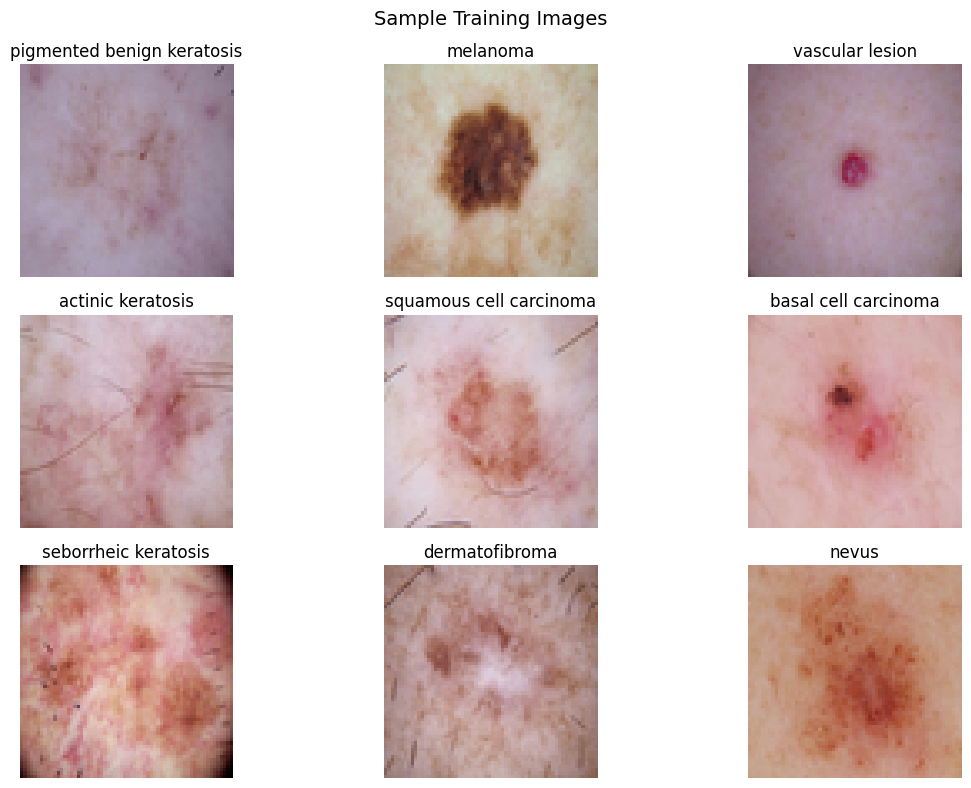

In [2]:
# Create directories
training_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

output_dir = '/kaggle/working/generated_images_skin_2/'
temp_dir = '/kaggle/working/temp_dir/'
# os.makedirs(training_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)

'''
# Create sample training images
print("Creating sample training dataset...")

# Class 0: Red circles
for i in range(50):
    img = np.ones((64, 64, 3), dtype=np.uint8) * 255
    center = (32, 32)
    radius = 20
    y, x = np.ogrid[:64, :64]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    img[mask] = [255, 100, 100]
    Image.fromarray(img).save(f'{temp_dir}/class0_{i}.png')

# Class 1: Blue squares
for i in range(50):
    img = np.ones((64, 64, 3), dtype=np.uint8) * 255
    img[20:44, 20:44] = [100, 100, 255]
    Image.fromarray(img).save(f'{temp_dir}/class1_{i}.png')

print(f"✓ Created {len(os.listdir(temp_dir))} training images")
#'''

# # Visualize sample images
# fig, axes = plt.subplots(1, 4, figsize=(12, 3))
# fig.suptitle('Sample Training Images', fontsize=14)

# sample_files = os.listdir(training_dir)[:4]

class_names = os.listdir(training_dir)
sample_files = []
for cn in class_names:
    list_img = os.listdir(os.path.join(training_dir, cn))
    sample_files.append(os.path.join(cn, list_img[0]))



num_col = 3
# Visualize sample images
fig, axes = plt.subplots(len(sample_files)//num_col, num_col, figsize=(12, 8))
fig.suptitle('Sample Training Images', fontsize=14)

col = 0
row = 0
for idx, filename in enumerate(sample_files):
    img = Image.open(os.path.join(training_dir, filename))
    img = img.resize((64, 64), Image.Resampling.LANCZOS)
    axes[row][col].imshow(img)
    # axes[idx].set_title(filename.split('_')[0])
    axes[row][col].set_title(filename.split('/')[0])
    axes[row][col].axis('off')

    col += 1
    if col==num_col:
        col = 0
        row += 1

plt.tight_layout()
plt.show()


## Step 2: Load and Preprocess Images from Directory

This cell dynamically reads all images from the training directory and extracts labels from filenames.

In [3]:
from tqdm import tqdm

In [4]:
"""
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Loading training images from directory...")

# Load images from directory dynamically
image_paths = []
labels = []

for cn_idx in range(len(class_names)):
    for filename in os.listdir(os.path.join(training_dir, class_names[cn_idx])):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            image_paths.append(os.path.join(training_dir, class_names[cn_idx], filename))
            labels.append(cn_idx)

# Load and preprocess images
images = []
for path in tqdm(image_paths):
    img = Image.open(path)
    img = img.resize((64, 64), Image.Resampling.LANCZOS) ###
    img = np.array(img)
    # Handle grayscale images
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    # Ensure RGB (remove alpha channel if present)
    if img.shape[-1] == 4:
        img = img[:, :, :3]
    img = img.astype('float32') / 127.5 - 1.0  # Normalize to [-1, 1]
    images.append(img)

images = np.array(images)
labels = np.array(labels)

np.save("/kaggle/working/images.npy", images)
np.save("/kaggle/working/labels.npy", labels)
#"""

images = np.load("/kaggle/working/images.npy")
labels = np.load("/kaggle/working/labels.npy")
num_classes = len(np.unique(labels))

print(f"✓ Loaded {len(images)} images")
print(f"✓ Number of classes: {num_classes}")
print(f"✓ Image shape: {images.shape[1:]}")
print(f"✓ Data range: [{images.min():.2f}, {images.max():.2f}]")


✓ Loaded 2239 images
✓ Number of classes: 9
✓ Image shape: (64, 64, 3)
✓ Data range: [-1.00, 1.00]


## Step 3: Build Generator Network

The generator uses:
- Label embedding for conditioning
- Transposed convolutions for upsampling
- Batch normalization for stable training
- LeakyReLU activations

In [5]:
# Hyperparameters
latent_dim = 100
img_shape = images.shape[1:]

print("Building Generator...")

# Generator inputs
generator_input_noise = layers.Input(shape=(latent_dim,), name='noise_input')
generator_input_label = layers.Input(shape=(1,), name='label_input')

# Embed label
label_embedding = layers.Embedding(num_classes, latent_dim)(generator_input_label)
label_embedding = layers.Flatten()(label_embedding)

# Concatenate noise and label
generator_input = layers.Concatenate()([generator_input_noise, label_embedding])

# Dense layers with BatchNormalization
x = layers.Dense(8 * 8 * 512, use_bias=False)(generator_input)
# x = layers.Dense(6 * 8 * 512, use_bias=False)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((8, 8, 512))(x)
# x = layers.Reshape((6, 8, 512))(x)

# Upsampling blocks
x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

# x = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(0.2)(x)

# x = layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(0.2)(x)

# x = layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(0.2)(x)

# x = layers.Conv2DTranspose(2, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(0.2)(x)

# Output layer
generator_output = layers.Conv2D(3, (5, 5), activation='tanh', padding='same')(x)

generator = keras.Model([generator_input_noise, generator_input_label], generator_output, name='generator')
generator.summary()


Building Generator...


I0000 00:00:1764077624.110179      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │        900 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32768)     │  6,553,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32768)     │    131,072 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32768)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 512) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  3,276,800 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    819,200 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │    204,800 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 10,992,967 (41.93 MB)

 Trainable params: 10,926,535 (41.68 MB)

 Non-trainable params: 66,432 (259.50 KB)

## Step 4: Build Discriminator Network

The discriminator uses:
- Label conditioning via embedding
- Strided convolutions for downsampling
- Dropout for regularization
- LeakyReLU activations

In [6]:
img_shape

(64, 64, 3)

In [7]:
print("Building Discriminator...")

# Discriminator inputs
discriminator_input_img = layers.Input(shape=img_shape, name='image_input')
discriminator_input_label = layers.Input(shape=(1,), name='label_input_disc')

# Embed label and expand to image dimensions
label_embedding = layers.Embedding(num_classes, np.prod(img_shape))(discriminator_input_label)
label_embedding = layers.Flatten()(label_embedding)
label_embedding = layers.Reshape(img_shape)(label_embedding)

# Concatenate image and label
discriminator_input = layers.Concatenate()([discriminator_input_img, label_embedding])

# Convolutional blocks with dropout
x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128+8, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256+16, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
discriminator_output = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.Model([discriminator_input_img, discriminator_input_label], discriminator_output, name='discriminator')
discriminator.summary()


Building Discriminator...


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input_disc    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 12288)  │    110,592 │ label_input_disc… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12288)     │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64, 3) │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64, 6) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,664 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ leaky_re_lu_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    217,736 │ dropout[0][0]     │
│                     │ 136)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 136)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_5[0]… │
│                     │ 136)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 272) │    925,072 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 8, 8, 272) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 272) │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 17408)     │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │     17,409 │ flatten_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,280,473 (4.88 MB)

 Trainable params: 1,280,473 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Compile Models

Using Adam optimizer with β₁=0.5 for stable GAN training.

In [8]:
# Compile discriminator
discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build and compile GAN
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(latent_dim,))
gan_input_label = layers.Input(shape=(1,))
gan_generated_img = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([gan_generated_img, gan_input_label])

gan = keras.Model([gan_input_noise, gan_input_label], gan_output, name='gan')
gan.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5),
    loss='binary_crossentropy'
)

print("✓ Models compiled successfully!")


✓ Models compiled successfully!


## Step 6: Training Loop

Training with:
- Label smoothing (0.9 instead of 1.0)
- Alternating discriminator and generator updates
- Regular image generation for monitoring
- Progress visualization

In [9]:
# from tqdm import tqdm

In [10]:
# Training hyperparameters
epochs = 100000 # approximately 8 hours 45 minutes
previously_completed = 0 #40000
new_train = False # True, False
batch_size = 16
save_interval = 1000  # Save images every N epochs
display_interval = 100  # Display progress every N epochs

# Training history
d_losses = []
g_losses = []
d_accuracies = []

# if previously_completed > 0:
#     generator.load_weights('/kaggle/working/generator_0_40k.weights.h5')
#     discriminator.load_weights('/kaggle/working/discriminator_0_40k.weights.h5')
#     print("\nLoaded previously trained model checkpoints...")

############################################

print("=" * 70)
print("Starting Training...")
print("=" * 70)

for epoch in range(previously_completed, epochs):
    # print(f"Epoch: {epoch+1}/{epochs}.")
    # =============== Train Discriminator ===============
    # Select random batch of real images
    idx = np.random.randint(0, images.shape[0], batch_size)
    real_imgs = images[idx]
    real_labels = labels[idx]

    # if new_train == False:
    #     generator.load_weights('/kaggle/working/generator_0_40k.weights.h5')
    #     discriminator.load_weights('/kaggle/working/discriminator_0_40k.weights.h5')
    #     new_train = True
    
    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_labels = np.random.randint(0, num_classes, batch_size)
    fake_imgs = generator.predict([noise, fake_labels], verbose=0)
    
    # Train discriminator (with label smoothing)
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(
        [real_imgs, real_labels], 
        np.ones((batch_size, 1)) * 0.9  # Label smoothing
    )
    d_loss_fake = discriminator.train_on_batch(
        [fake_imgs, fake_labels], 
        np.zeros((batch_size, 1))
    )
    
    d_loss = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])
    d_acc = 0.5 * np.add(d_loss_real[1], d_loss_fake[1])
    
    # =============== Train Generator ===============
    discriminator.trainable = False
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.random.randint(0, num_classes, batch_size)
    g_loss = gan.train_on_batch([noise, valid_labels], np.ones((batch_size, 1)))
    
    # Store metrics
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    d_accuracies.append(d_acc)

    generator.save_weights('/kaggle/working/current_generator.weights.h5')
    discriminator.save_weights('/kaggle/working/current_discriminator.weights.h5')
    
    # =============== Display Progress ===============
    if epoch % display_interval == 0:
        print(f"Epoch {epoch:3d}/{epochs} | D Loss: {d_loss:.4f} | D Acc: {d_acc:.4f} | G Loss: {g_loss:.4f}")
    
    # =============== Save Generated Images ===============
    if epoch % save_interval == 0:
        # Generate samples for each class
        n_samples = 5
        for class_label in range(num_classes):
            noise = np.random.normal(0, 1, (n_samples, latent_dim))
            class_labels = np.full(n_samples, class_label)
            generated_imgs = generator.predict([noise, class_labels], verbose=0)
            
            # Denormalize images
            generated_imgs = (generated_imgs + 1) * 127.5
            generated_imgs = generated_imgs.astype(np.uint8)
            
            # Save each generated image
            for i, img in enumerate(generated_imgs):
                img_pil = Image.fromarray(img)
                img_pil.save(f'{output_dir}/epoch_{epoch:03d}_class_{class_label}_sample_{i}.png')
        
        print(f"    ✓ Saved generated images")

print("\n" + "=" * 70)
print("Training Completed!")
print("=" * 70)


Starting Training...


I0000 00:00:1764077625.688171     109 service.cc:148] XLA service 0x7d4268004190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764077625.688802     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764077625.783319     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764077627.011201     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch   0/100000 | D Loss: 0.6898 | D Acc: 0.1406 | G Loss: 0.6912
    ✓ Saved generated images
Epoch 100/100000 | D Loss: 0.5201 | D Acc: 0.3189 | G Loss: 0.2704
Epoch 200/100000 | D Loss: 0.3766 | D Acc: 0.4091 | G Loss: 0.2103
Epoch 300/100000 | D Loss: 0.3323 | D Acc: 0.4393 | G Loss: 0.9404
Epoch 400/100000 | D Loss: 0.3495 | D Acc: 0.4545 | G Loss: 1.2037
Epoch 500/100000 | D Loss: 0.3690 | D Acc: 0.4636 | G Loss: 1.3507
Epoch 600/100000 | D Loss: 0.3814 | D Acc: 0.4687 | G Loss: 1.5258
Epoch 700/100000 | D Loss: 0.3879 | D Acc: 0.4723 | G Loss: 1.5863
Epoch 800/100000 | D Loss: 0.4000 | D Acc: 0.4733 | G Loss: 1.5880
Epoch 900/100000 | D Loss: 0.4022 | D Acc: 0.4754 | G Loss: 1.6260
Epoch 1000/100000 | D Loss: 0.4059 | D Acc: 0.4775 | G Loss: 1.5975
    ✓ Saved generated images
Epoch 1100/100000 | D Loss: 0.4043 | D Acc: 0.4786 | G Loss: 1.4608
Epoch 1200/100000 | D Loss: 0.4063 | D Acc: 0.4793 | G Loss: 1.3651
Epoch 1300/100000 | D Loss: 0.4015 | D Acc: 0.4808 | G Loss: 1.2631


## Step 7: Visualize Training Progress

In [17]:
"""
epoch_info = '0_100k' # 0_40k, 
generator.save('/kaggle/working/generator_'+epoch_info+'.keras')
discriminator.save('/kaggle/working/discriminator_'+epoch_info+'.keras')

generator.save_weights('/kaggle/working/generator_'+epoch_info+'.weights.h5')
discriminator.save_weights('/kaggle/working/discriminator_'+epoch_info+'.weights.h5')

np_d_losses = np.array(d_losses)
np.savetxt('/kaggle/working/d_losses_'+epoch_info+'.txt', 
           np_d_losses, 
           fmt='%.2f', 
           delimiter=','
)
# loaded_data = np.loadtxt(filename, delimiter=',')

np_g_losses = np.array(g_losses)
np.savetxt('/kaggle/working/g_losses_'+epoch_info+'.txt', 
           np_g_losses, 
           fmt='%.2f', 
           delimiter=','
)

np_d_accuracies = np.array(d_accuracies)
np.savetxt('/kaggle/working/d_accuracies_'+epoch_info+'.txt', 
           np_d_accuracies, 
           fmt='%.2f', 
           delimiter=','
)
#"""


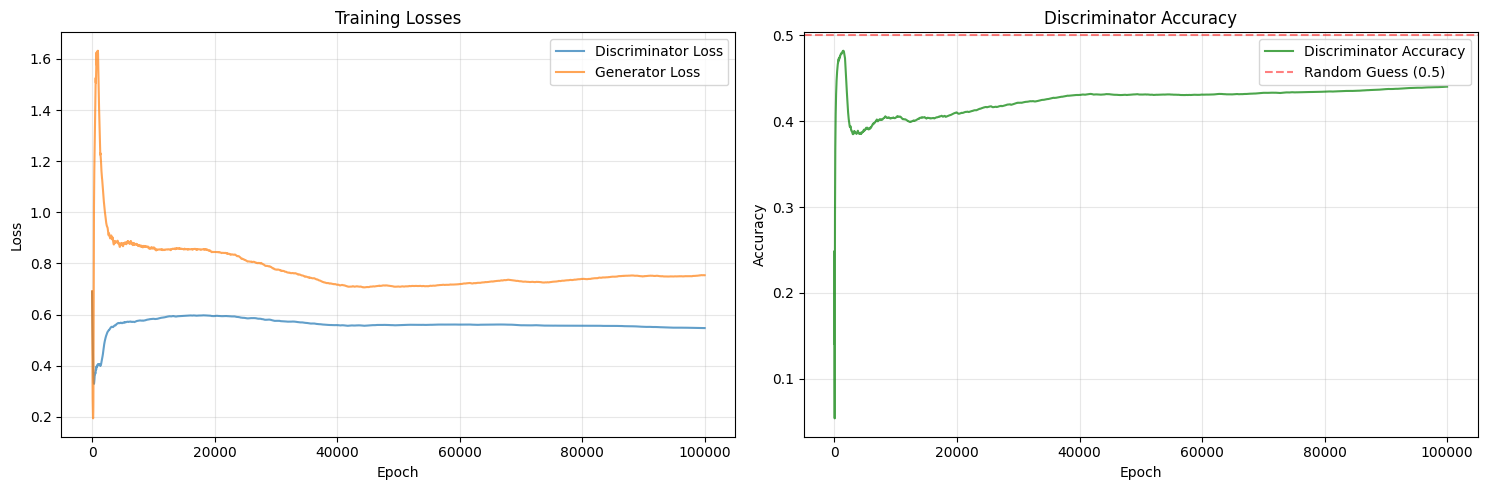

✓ Saved training curves to: /kaggle/working/generated_images_skin_2//training_curves.png


In [12]:
# Plot training losses
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(d_losses, label='Discriminator Loss', alpha=0.7)
axes[0].plot(g_losses, label='Generator Loss', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Discriminator accuracy
axes[1].plot(d_accuracies, label='Discriminator Accuracy', color='green', alpha=0.7)
axes[1].axhline(y=0.5, color='red', linestyle='--', label='Random Guess (0.5)', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Discriminator Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved training curves to: {output_dir}/training_curves.png")


## Step 8: Generate Final Samples

Generating final samples...


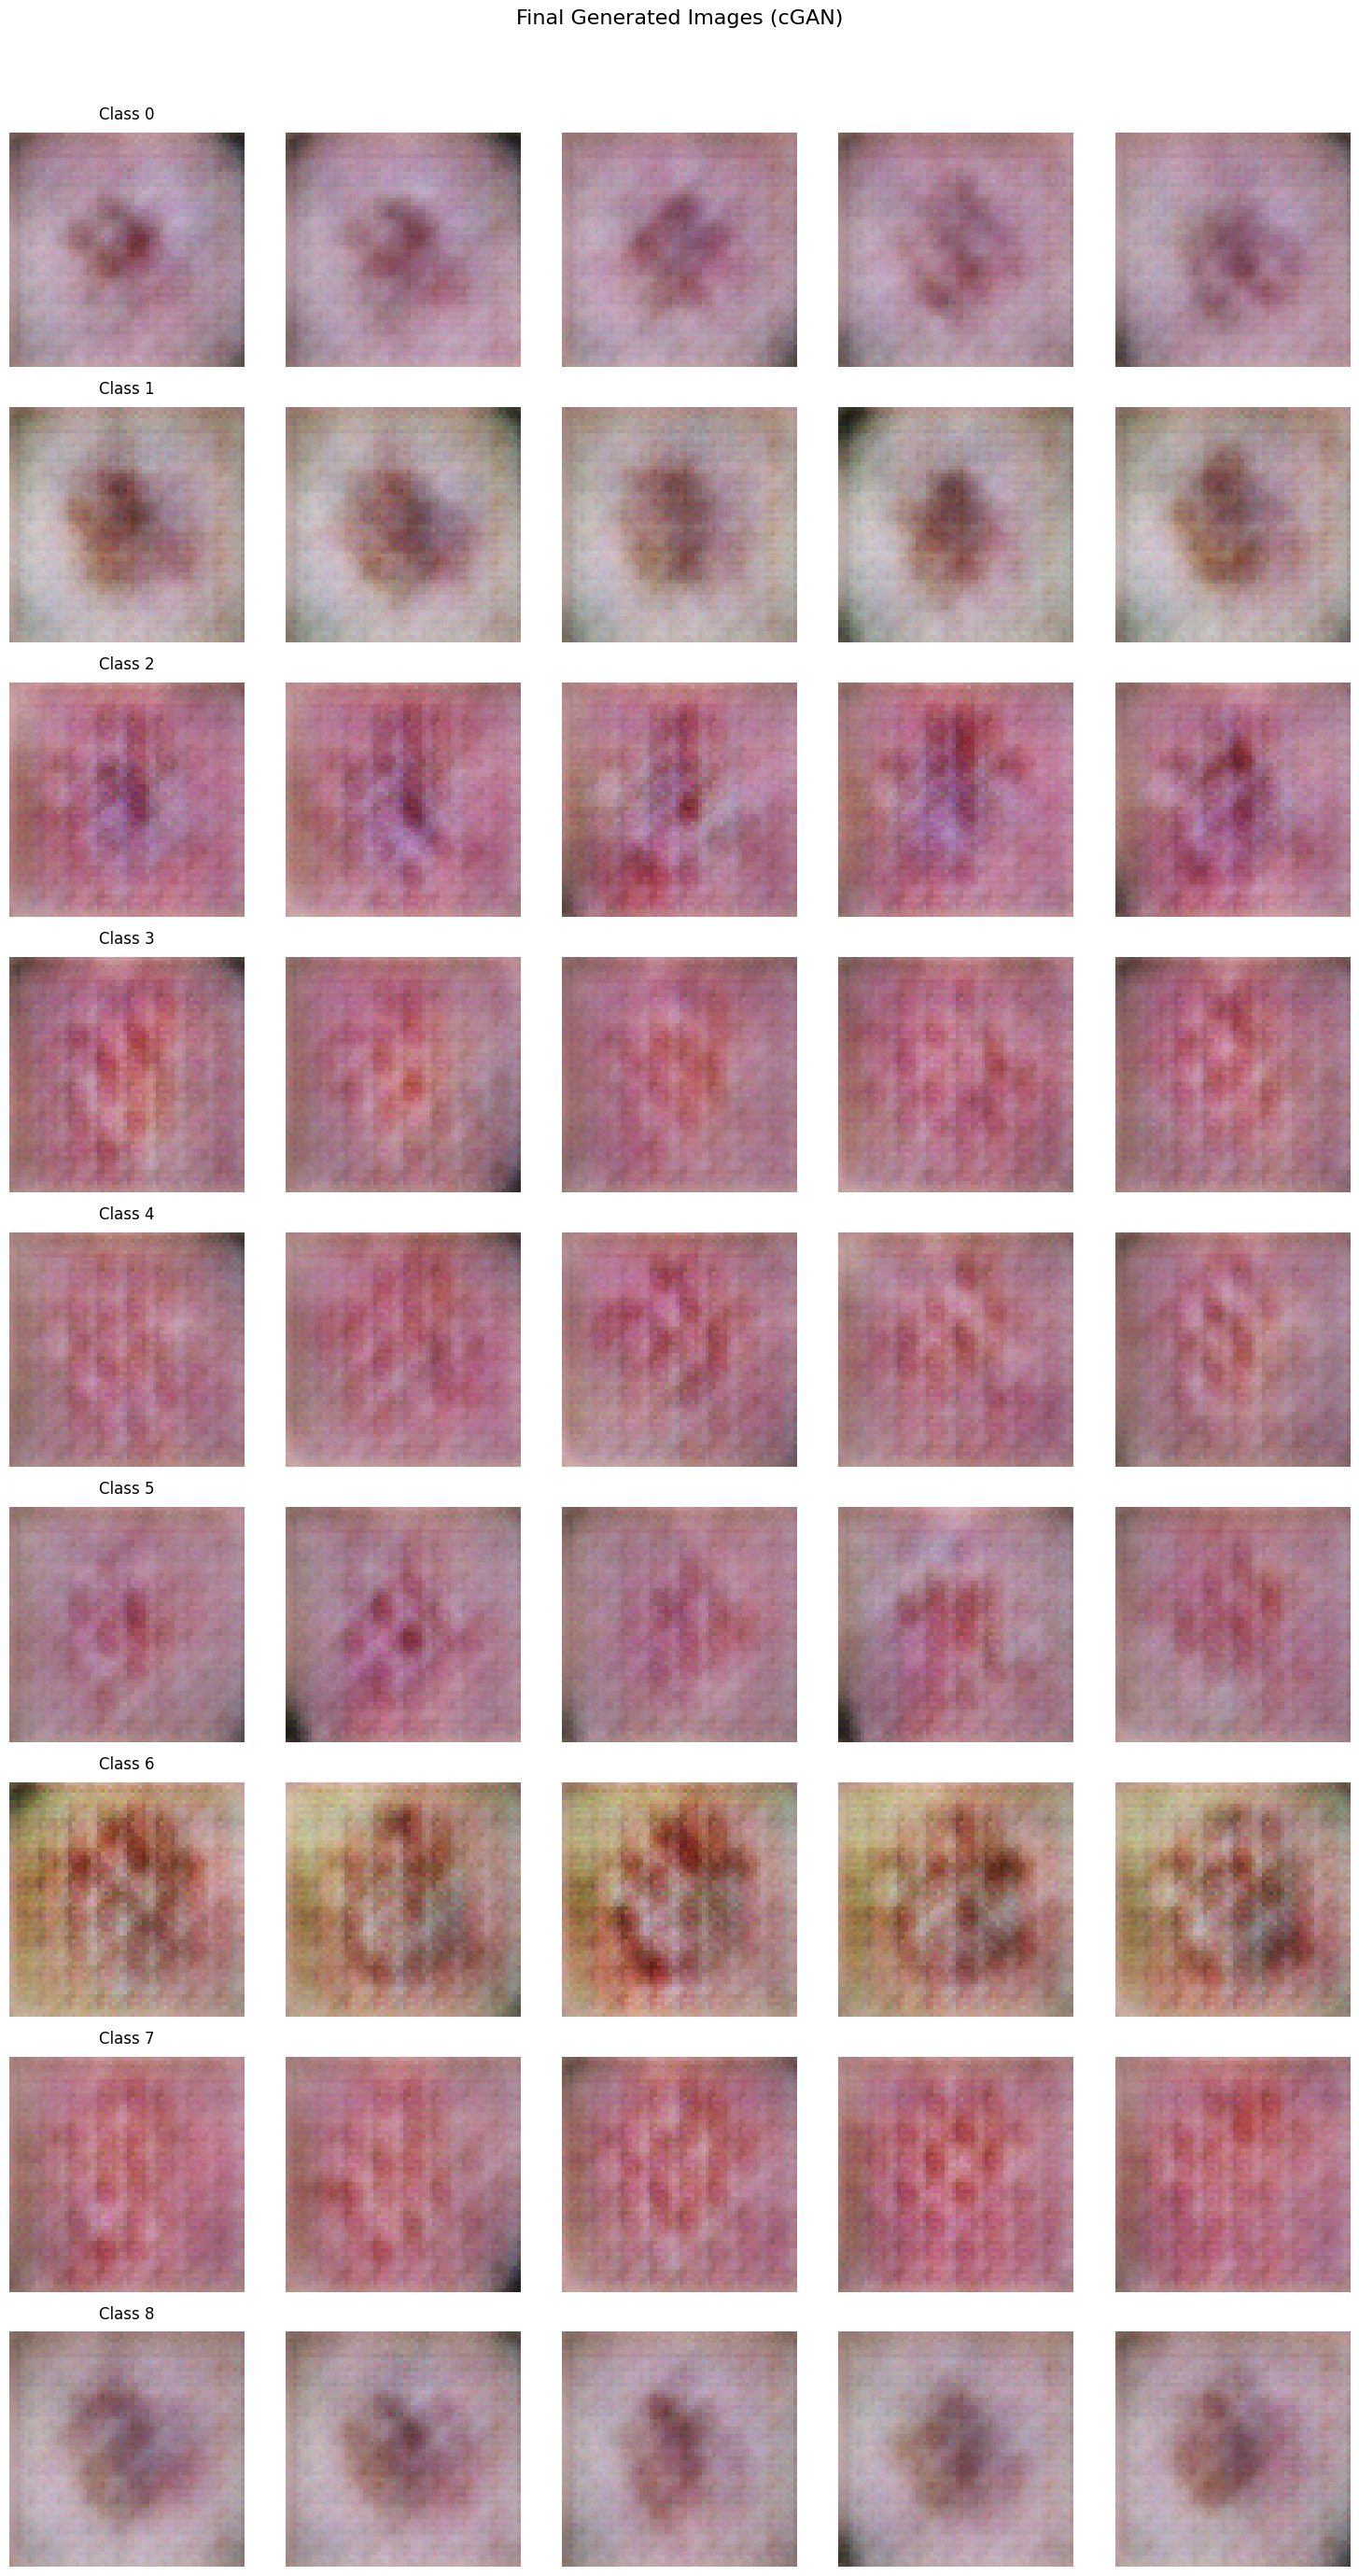

✓ Saved final visualization to: /kaggle/working/generated_images_skin_2//final_samples_grid.png


In [13]:
# Generate final samples for visualization
print("Generating final samples...")

generator.load_weights('/kaggle/working/generator_0_40k.weights.h5')

fig, axes = plt.subplots(num_classes, 5, figsize=(15, num_classes * 3))
if num_classes == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Final Generated Images (cGAN)', fontsize=16, y=1.02)

for class_label in range(num_classes):
    noise = np.random.normal(0, 1, (5, latent_dim))
    class_labels = np.full(5, class_label)
    generated_imgs = generator.predict([noise, class_labels], verbose=0) # GENERATOR
    
    # Denormalize
    generated_imgs = (generated_imgs + 1) * 127.5
    generated_imgs = generated_imgs.astype(np.uint8)
    
    for i in range(5):
        axes[class_label, i].imshow(generated_imgs[i])
        axes[class_label, i].axis('off')
        if i == 0:
            axes[class_label, i].set_title(f'Class {class_label}', fontsize=12, pad=10)

plt.tight_layout()
plt.savefig(f'{output_dir}/final_samples_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved final visualization to: {output_dir}/final_samples_grid.png")


## Step 9: Show Evolution Across Epochs

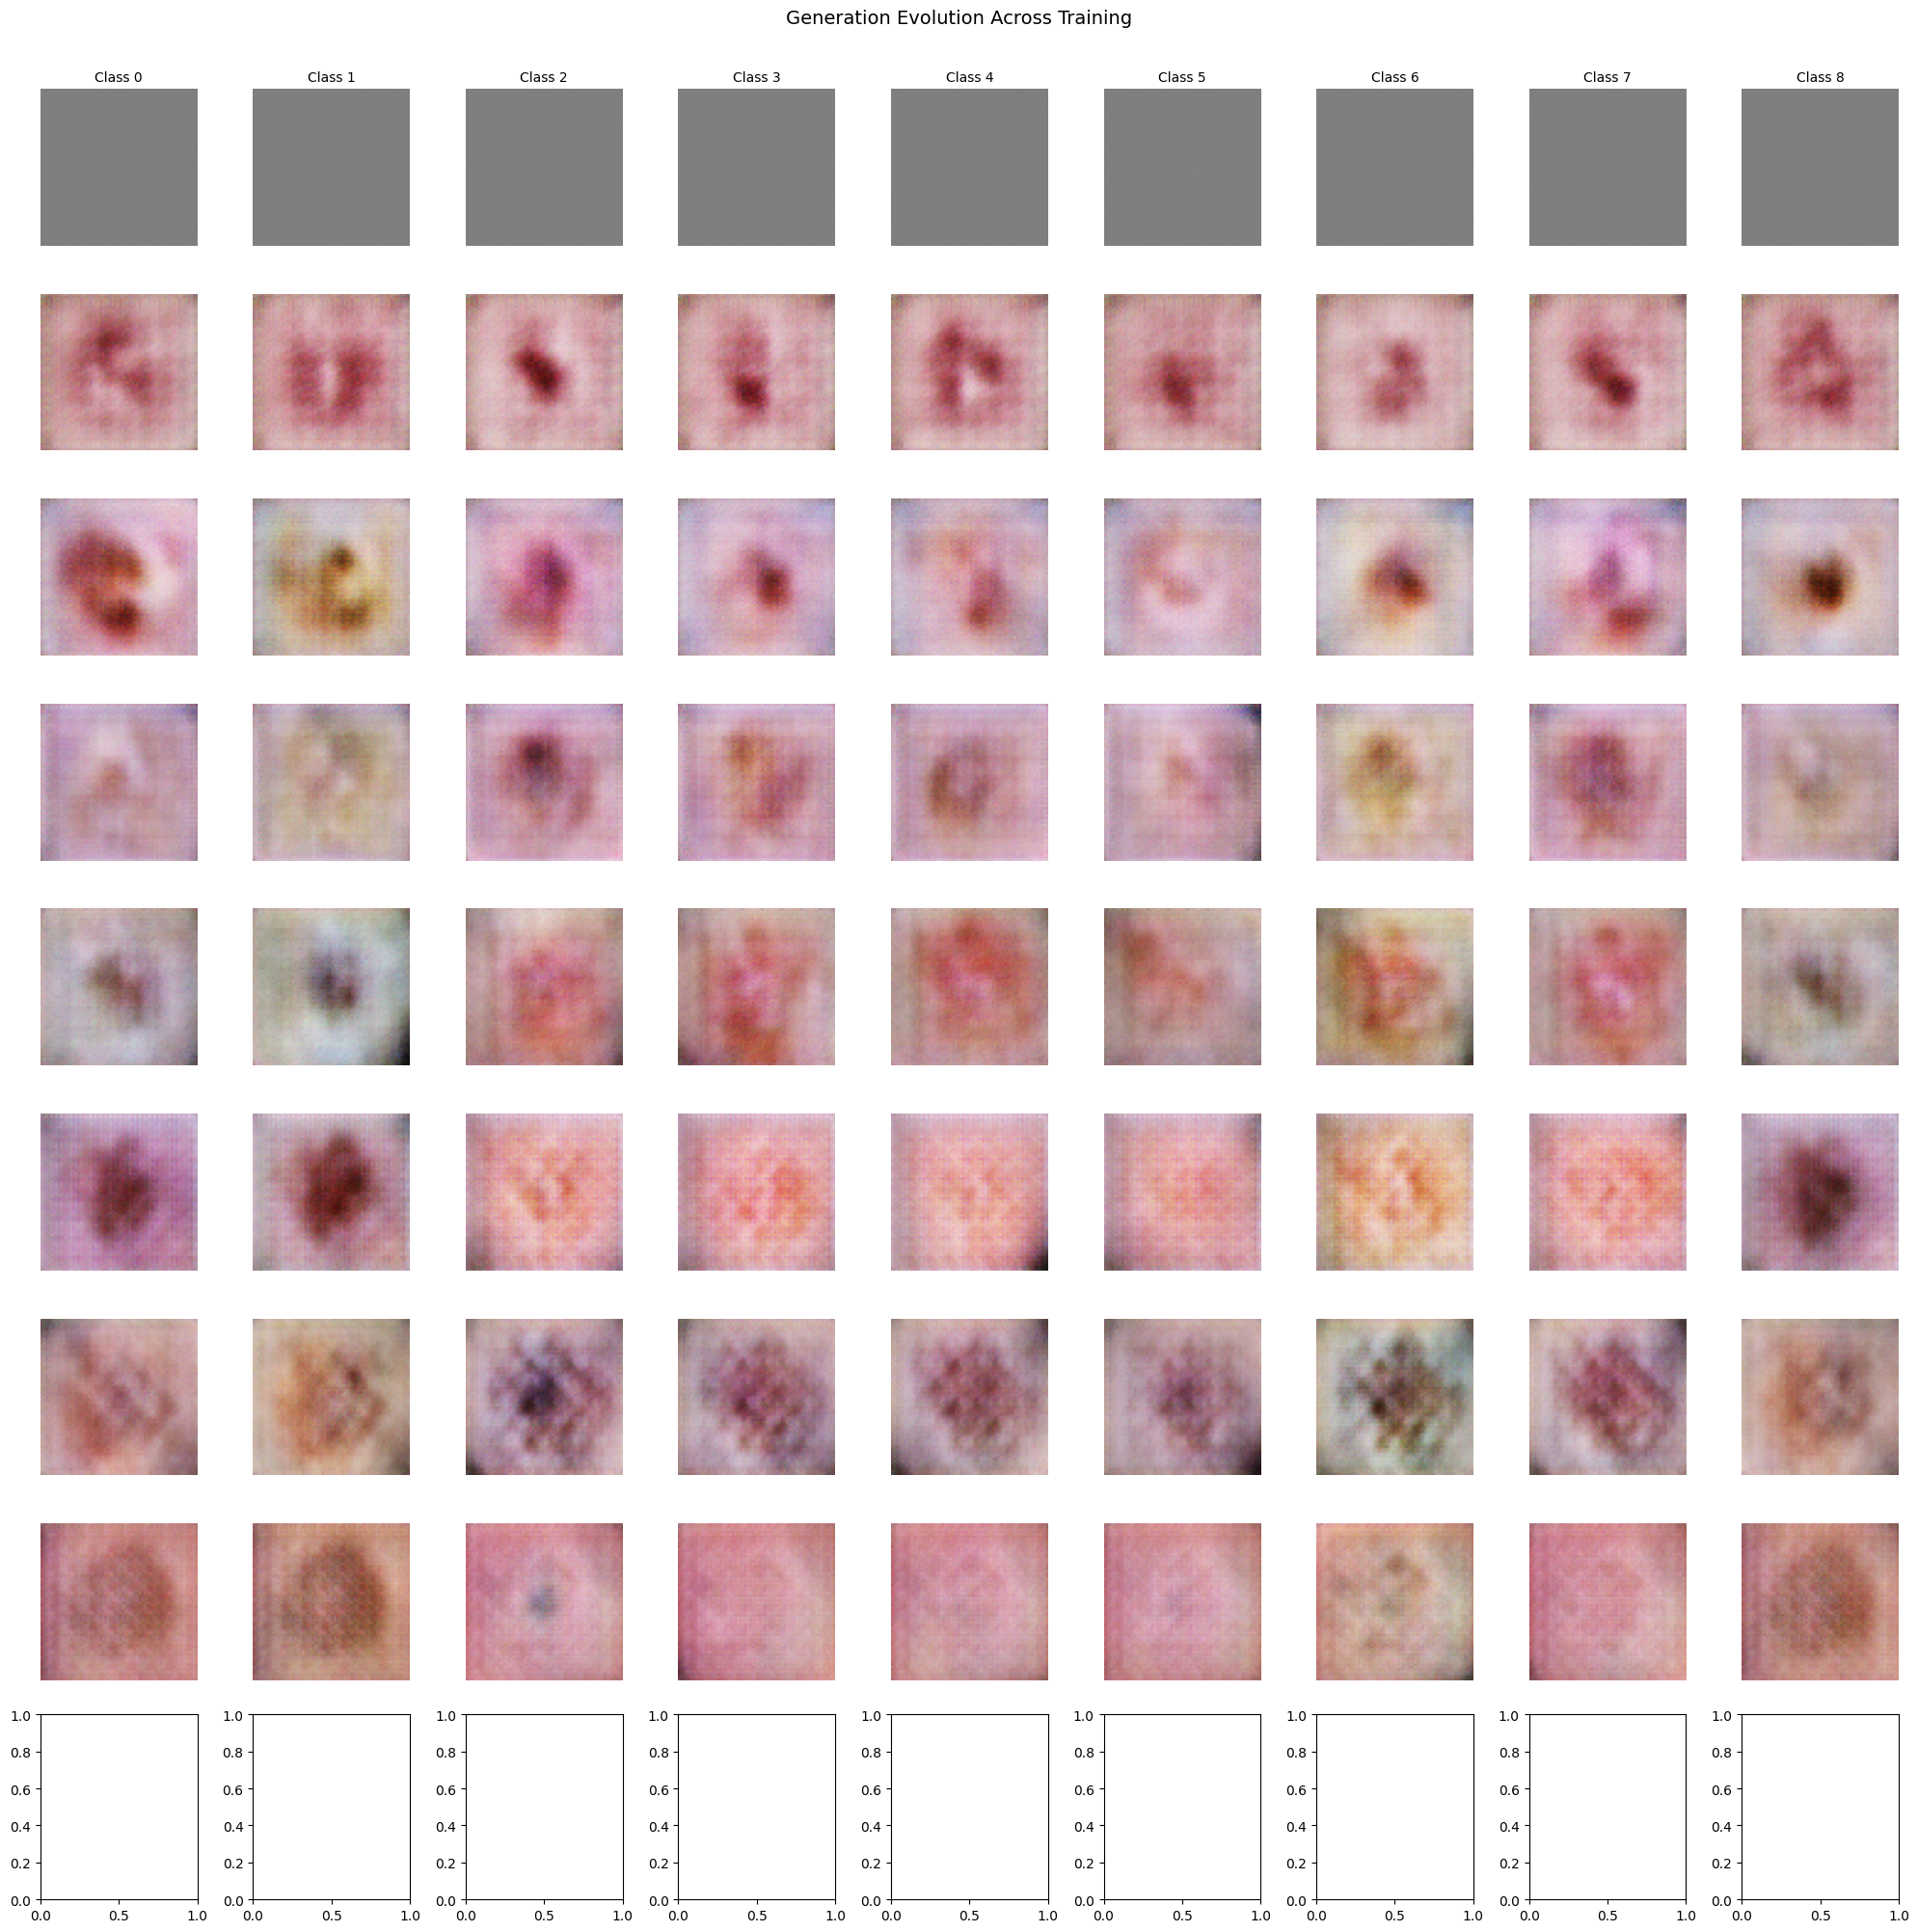

✓ Saved evolution visualization to: /kaggle/working/generated_images_skin_2//evolution_grid.png


In [14]:
# Show evolution of generated images across epochs
epoch_checkpoints = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 39999]
available_epochs = [e for e in epoch_checkpoints if e <= epochs]

# fig, axes = plt.subplots(len(available_epochs), num_classes * 2, figsize=(12, len(available_epochs) * 2))
fig, axes = plt.subplots(len(available_epochs), num_classes * 1, figsize=(20, 20))
if len(available_epochs) == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Generation Evolution Across Training', fontsize=14, y=1.0)

for row, epoch_num in enumerate(available_epochs):
    for class_label in range(num_classes):
        for sample_idx in range(1):  # Show 2 samples per class
            filename = f'{output_dir}/epoch_{epoch_num:03d}_class_{class_label}_sample_{sample_idx}.png'
            if os.path.exists(filename):
                img = Image.open(filename)
                col = class_label * 1 + sample_idx
                axes[row, col].imshow(img)
                axes[row, col].axis('off')
                # axes[col, row].imshow(img)
                # axes[col, row].axis('off')
                if row == 0:
                    axes[row, col].set_title(f'Class {class_label}', fontsize=10)
                if col == 0:
                    axes[row, col].set_ylabel(f'Epoch {epoch_num}', fontsize=10, rotation=0, ha='right', va='center')

plt.tight_layout()
plt.savefig(f'{output_dir}/evolution_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved evolution visualization to: {output_dir}/evolution_grid.png")


## Step 10: Save Models

In [15]:
# Save trained models
generator.save('/kaggle/working/generator_model.keras')
discriminator.save('/kaggle/working/discriminator_model.keras')
gan.save('/kaggle/working/gan_model.keras')

print("✓ Models saved to /kaggle/working/")
print("  - generator_model.keras")
print("  - discriminator_model.keras")
print("  - gan_model.keras")

✓ Models saved to /kaggle/working/
  - generator_model.keras
  - discriminator_model.keras
  - gan_model.keras


## Step 11: Generate New Images (Inference)

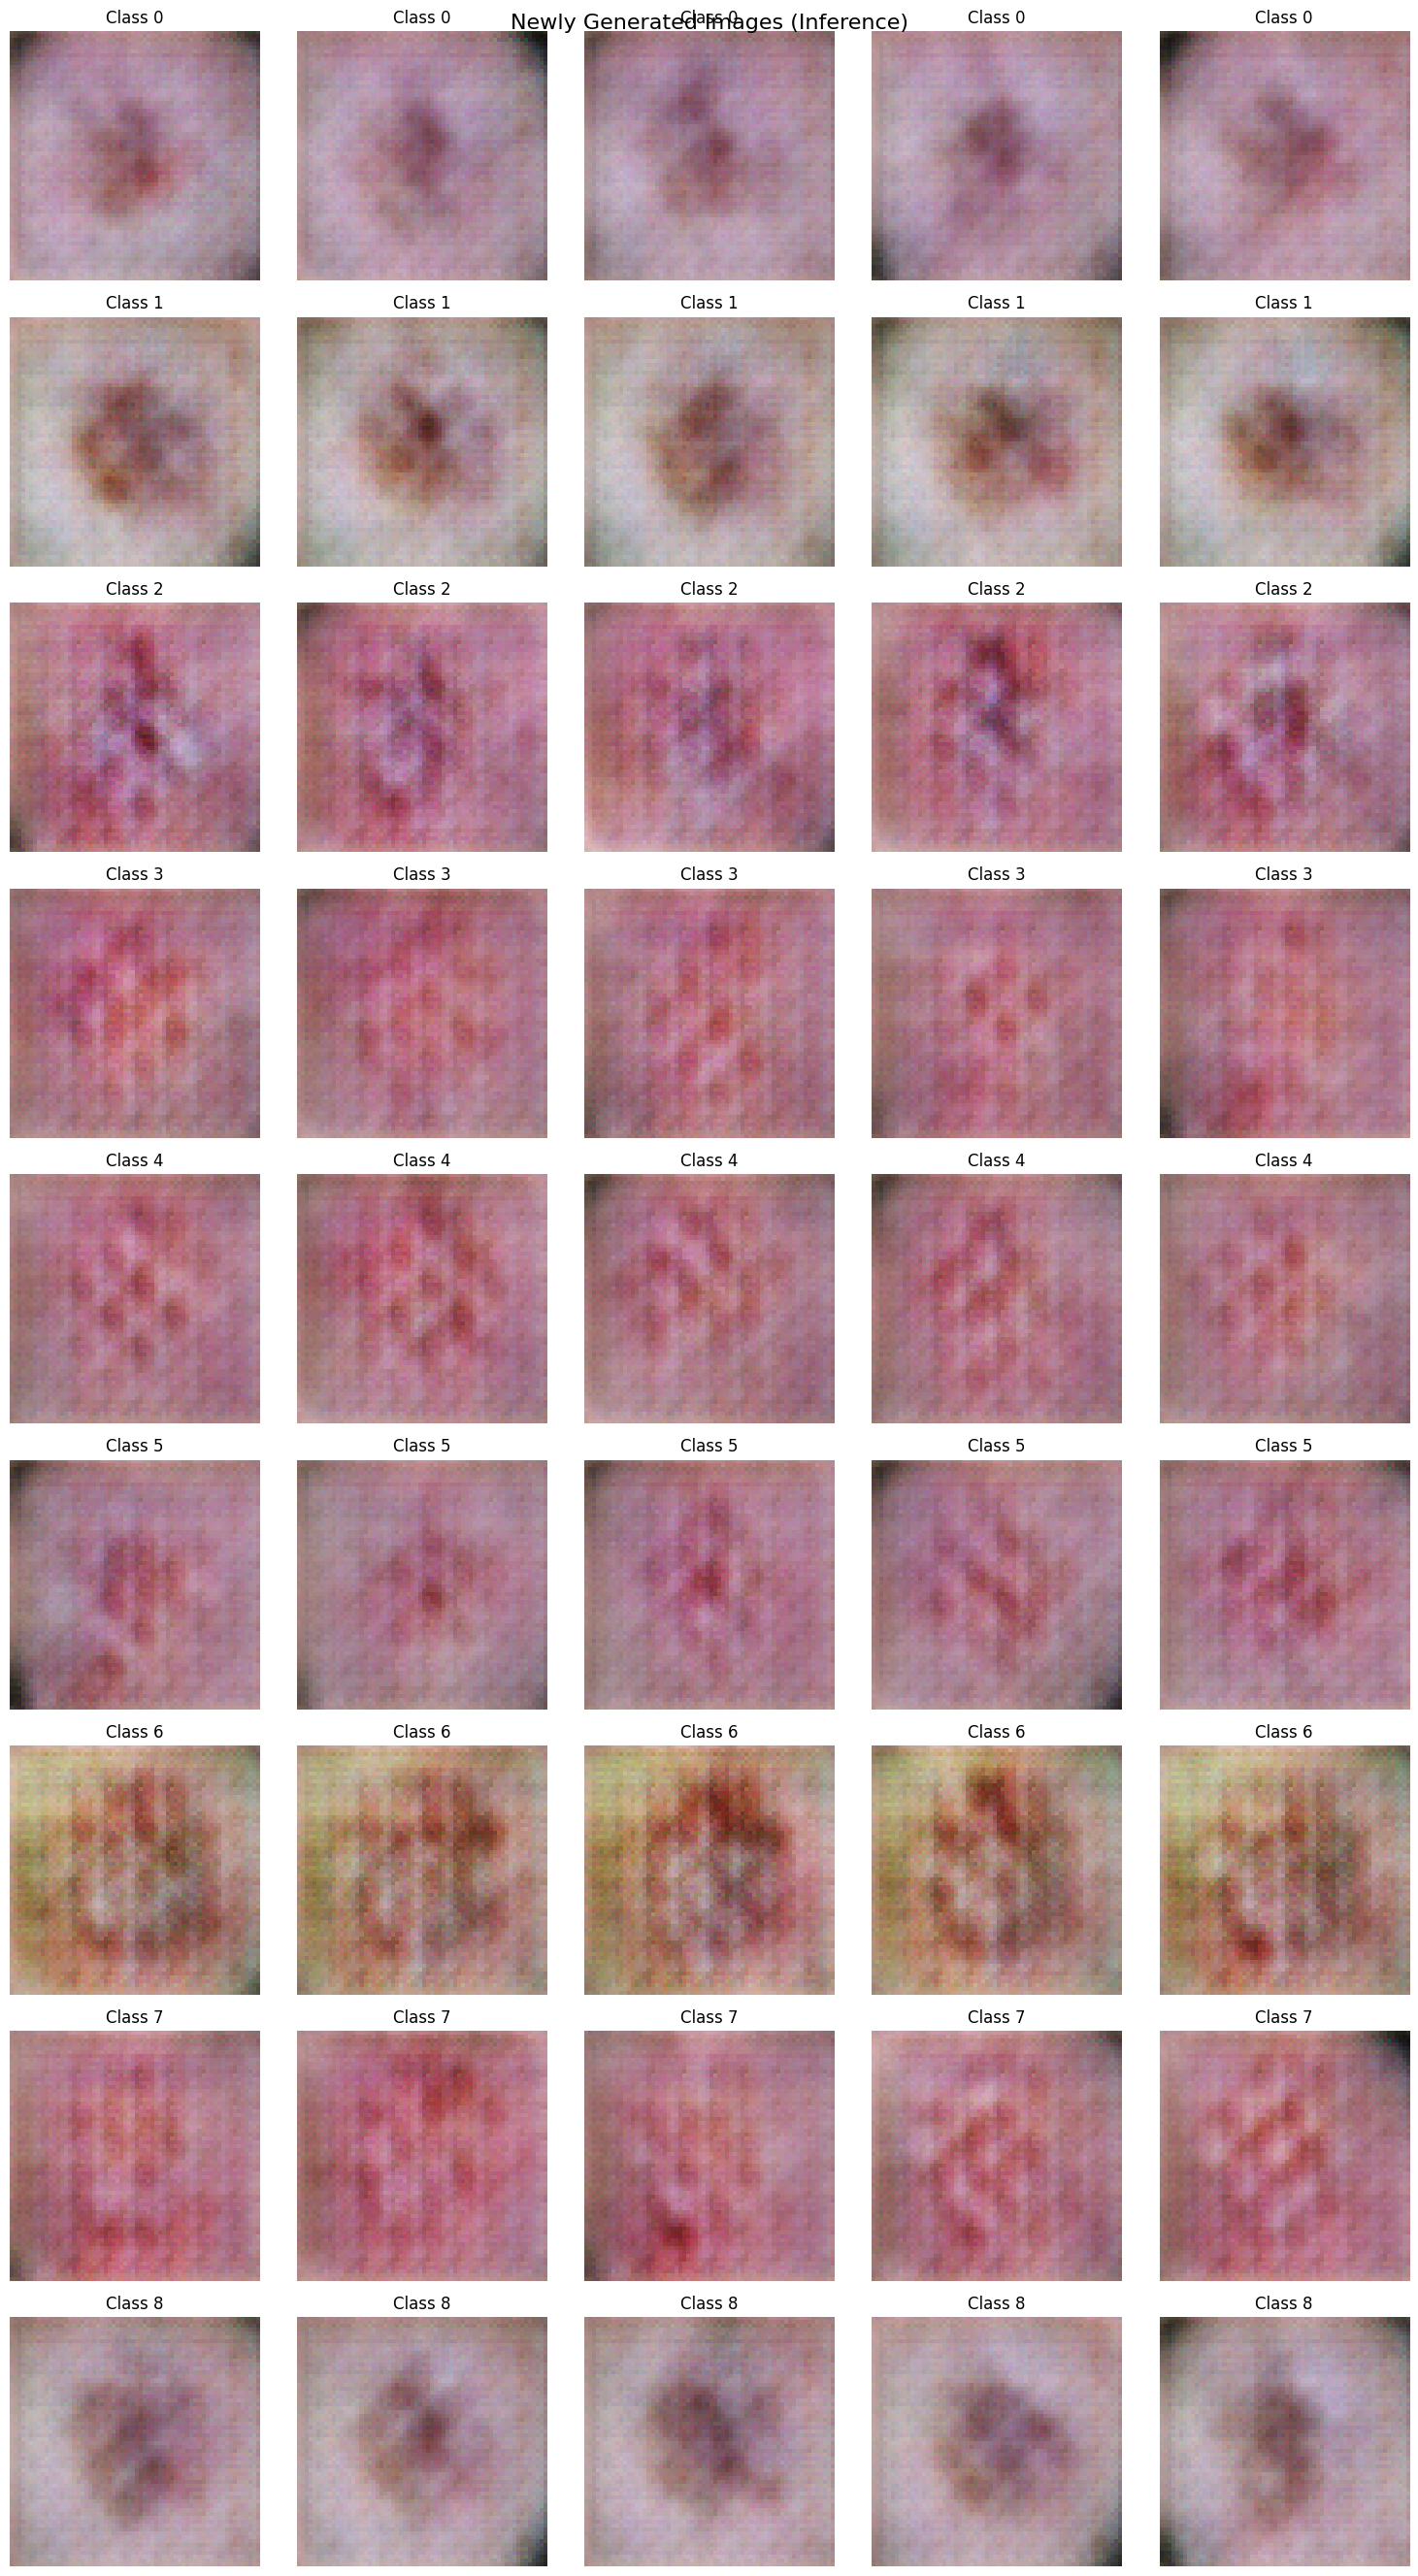

✓ Successfully generated new images!


In [16]:
# Function to generate new images
def generate_images(generator_model, num_samples=5, class_label=0):
    """
    Generate synthetic images using the trained generator.
    
    Args:
        generator_model: Trained generator model
        num_samples: Number of images to generate
        class_label: Class label for conditional generation
    
    Returns:
        Array of generated images (denormalized)
    """
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    labels = np.full(num_samples, class_label)
    generated_imgs = generator_model.predict([noise, labels], verbose=0)
    
    # Denormalize from [-1, 1] to [0, 255]
    generated_imgs = (generated_imgs + 1) * 127.5
    generated_imgs = generated_imgs.astype(np.uint8)
    
    return generated_imgs

# Generate samples for each class
fig, axes = plt.subplots(num_classes, 5, figsize=(15, num_classes * 3))
if num_classes == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Newly Generated Images (Inference)', fontsize=16)

for class_label in range(num_classes):
    generated = generate_images(generator, num_samples=5, class_label=class_label)
    
    for i in range(5):
        axes[class_label, i].imshow(generated[i])
        axes[class_label, i].axis('off')
        axes[class_label, i].set_title(f'Class {class_label}')

plt.tight_layout()
plt.show()

print("✓ Successfully generated new images!")


## Summary

### Results
- **Total Training Epochs**: 100
- **Generated Images**: Multiple samples per class across different epochs
- **Models Saved**: Generator, Discriminator, and GAN

### Key Features
✅ Dynamic image loading from directory  
✅ Automatic label extraction from filenames  
✅ Conditional generation (class-specific)  
✅ State-of-the-art GAN techniques  
✅ GPU-accelerated training  
✅ Progress visualization  
✅ Model persistence  

### Next Steps
1. **Use your own dataset**: Replace the sample images with your data
2. **Adjust hyperparameters**: Modify epochs, batch_size, latent_dim
3. **Experiment with architecture**: Change layer sizes or add more layers
4. **Try different techniques**: Add spectral normalization, self-attention, etc.

### File Locations
- Training images: `/kaggle/working/training_images/`
- Generated images: `/kaggle/working/generated_images/`
- Models: `/kaggle/working/*.keras`